# Portuguese GloVe Embeddings Bag Sentence Classification - Experimento

Este componente classifica sentenças baseado nos pacotes de Embeddings GloVe em português disponibilizados pelo [NILC](http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc)
Este notebook apresenta:
- como usar o [SDK](https://platiagro.github.io/sdk/) para carregar datasets, salvar modelos e outros artefatos.
- como declarar parâmetros e usá-los para criar componentes reutilizáveis.

## Declare parâmetros e hiperparâmetros para o modelo
Os componentes podem declarar (e usar) estes parâmetros como padrão:
- dataset
- target

Use estes parâmetros para carregar/salvar conjutos de dados, modelos, métricas e figuras com a ajuda do [SDK da PlatIAgro](https://platiagro.github.io/sdk/). <br>
É possível também declarar parâmetros personalizados para serem definidos ao executar um experimento. 

Selecione os hiperparâmetros e seus respectivos valores para serem usados ao treinar o modelo:
- language

Estes parâmetros são alguns dos oferecidos pela classe do modelo, você também pode utilizar outros existentes. <br>
Dê uma olhada nos [parâmetros do modelo](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn-impute-simpleimputer) para mais informações.

In [8]:
# parâmetros
dataset = "/tmp/data/jira-2.csv" #@param {type:"string"}
target = "issuetype" #@param {type:"string", label:"Atributo alvo", description:"Seu modelo será treinado para prever os valores do alvo."}
language = "portuguese" #@param ["portuguese", "english"] {type:"string", label:"Linguagem", description:"Linguagem da qual os stopwords pertencem. Deve ser a mesma utilizada no dataset."}

#Hyperparâametros
train_batch_size = 10 #@param {type:"integer"}
eval_batch_size = 2 #@param {type:"integer"}
max_epochs = 200 #@param {type:"integer"}
accumulate_grad_batches = 1  #@param {type:"integer"}
learning_rate = 0.12 #@param {type:"number"}
seed =7 #@param {type:"integer"}
hidden_dim  =300 #@param {type:"integer"}

# selected features to perform the model
filter_type = "incluir" #@param ['incluir','remover']  {type:"string",label:"Modo de seleção das features", description:"Se deseja informar quais features deseja incluir no modelo, selecione a opção [incluir]. Caso deseje informar as features que não devem ser utilizadas, selecione [remover]. "}
model_features = "description" #@param {type:"string",multiple:true,label:"Features para incluir/remover no modelo",description:"Seu modelo será feito considerando apenas as features selecionadas. Caso nada seja especificado, todas as features serão utilizadas"}

# preprocessamento
case = 'Lower' #@param ['Lower','Upper','NotApply']  {type:"string",label:"Aplicação de casing", description:"Caixa baixa, caixa alta ou não aplicação de caixa"}
remove_stop_words = True #@param [True,False]  {type:"boolean",label:" Remoção de Stop Words", description:"Remoção de palavras, conjunções, artigos e outros"}
remove_top_words = True #@param [True,False]  {type:"boolean",label:" Remoção de Top Words", description:"Remoção dea porcentagem palavras mais frequentes no texto"}
top_words_percentage = 0.01 #@param {type:"number",label:" Porcentagem de Top Words", description:"Porcentagem das palavras mais frequentes no texto"}
stemming = False #@param [True,False]  {type:"boolean",label:"Stemming"}
lemmatization = True #@param [True,False]  {type:"boolean",label:"Lemmatization"}
remove_punctuation = True #@param [True,False]  {type:"boolean",label:"Remoção de pontuação"}
remove_line_braks = True #@param [True,False]  {type:"boolean",label:"Remoção de quebras de lina",description:"Remoção de quebras de linha por \n e \r"}
remove_accents= True #@param [True,False]  {type:"boolean",label:"Remoção de acentos"}
remove_html = True #@param [True,False]  {type:"boolean",label:"Remoção de HTML"}
remove_css = True #@param [True,False]  {type:"boolean",label:"Remoção de CSS"}

## Configurações Gerais



Definindo GPU como padrão e verificando status de hardware

In [9]:
from multiprocessing import cpu_count
import torch
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
if dev == "cpu":
    print(f"number of CPU cores: {cpu_count()}")
else:
    print(f"GPU: {torch.cuda.get_device_name(0)}, number of CPU cores: {cpu_count()}")

number of CPU cores: 12


Impedir excesso de logs

In [10]:
import logging
logging.getLogger("transformers.configuration_utils").setLevel(logging.WARNING)
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

Fixar semente de pesos aleatporios para replicabilidade

In [11]:
import random
random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [13]:
import pandas as pd
df = pd.read_csv(dataset)
df

,HD_ID,issuetype,summary,components,description,Unnamed: 5
0,HD-82125,Requisição,Jira e confluence não acessar sem VPN e VPN do...,VPN,Jira e confluence não acessar sem VPN e VPN do...,NaN
1,HD-82111,Requisição,DT para levar monitor de computador DELL para ...,Partes/peças,"Boa tarde, tudo bem?\n\nGostaria de solicitar,...",NaN
2,HD-82104,Requisição,Acesso ao Novo SVN,Jira,"Gustavo, boa tarde!\n\nPor gentileza, adiciona...",NaN
3,HD-82097,Requisição,Instalação de softwares - Troca de máquina,Software Windows,"Devido ao trabalho remoto, está inviável traba...",NaN
4,HD-82092,Incidente,Solicitação de perfil de administrador via aut...,Autoatendimento,Estou conectado na nova VPN do CPQD (via Forti...,NaN
...,...,...,...,...,...,...
12200,HD-68372,Requisição,Manutenção na instância awsdsda139,Nuvem,"Recebemos um comunicado da AWS, que foi detect...",NaN
12201,HD-68371,Requisição,Permissão de acesso ao JIRA-RN,Jira,Bom dia.\n\nSolicito acesso ao JIRA RN para o ...,NaN
12202,HD-68370,Requisição,Extração - Clientes Suspensos no E1,E1 Contratos,"{color:#000000}Bom dia Prezados, {color}\n\n{c...",NaN
12203,HD-68369,Incidente,Login no Windows - acesso à máquina,Conta de rede,O funcionário Vitor Hugo Silva Oliveira não es...,NaN


## Trabalhando os dados
Removendo as classes desnecessárias

In [14]:
df = df[[model_features, target]]
df = df.rename(columns={model_features: "text", target: "target"})
model_features, target = "text","target"
df = df[(df.target != 'Epic') & (df.target != 'Demanda') & (df.target != 'Bug') & (df.target != 'Sub-task')]
df

,text,target
0,Jira e confluence não acessar sem VPN e VPN do...,Requisição
1,"Boa tarde, tudo bem?\n\nGostaria de solicitar,...",Requisição
2,"Gustavo, boa tarde!\n\nPor gentileza, adiciona...",Requisição
3,"Devido ao trabalho remoto, está inviável traba...",Requisição
4,Estou conectado na nova VPN do CPQD (via Forti...,Incidente
...,...,...
12200,"Recebemos um comunicado da AWS, que foi detect...",Requisição
12201,Bom dia.\n\nSolicito acesso ao JIRA RN para o ...,Requisição
12202,"{color:#000000}Bom dia Prezados, {color}\n\n{c...",Requisição
12203,O funcionário Vitor Hugo Silva Oliveira não es...,Incidente


## Acesso aos metadados do conjunto de dados

Utiliza a função `stat_dataset` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para carregar metadados. <br>
Por exemplo, arquivos CSV possuem `metadata['featuretypes']` para cada coluna no conjunto de dados (ex: categorical, numerical, or datetime).

In [15]:
import numpy as np
#from platiagro import stat_dataset

#metadata = stat_dataset(name=dataset)
#featuretypes = metadata["featuretypes"]

columns = df.columns.to_numpy()
#featuretypes = np.array(featuretypes)
target_index = np.argwhere(columns == target)
columns = np.delete(columns, target_index)
#featuretypes = np.delete(featuretypes, target_index)

## Remoção de linhas com valores faltantes no atributo alvo

Caso haja linhas em que o atributo alvo contenha valores faltantes, é feita a remoção dos casos faltantes.

In [16]:
from sklearn.preprocessing import LabelEncoder

df.dropna(subset = [target],inplace=True)
df.dropna(subset = [model_features],inplace=True)
y = df[target].to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## Filtragem das features 

Seleciona apenas as features que foram declaradas no parâmetro model_features. Se nenhuma feature for especificada, todo o conjunto de dados será utilizado para a modelagem.

In [17]:
if filter_type == 'incluir':
    if len(model_features) >= 1:
        columns_index = (np.where(np.isin(columns,model_features)))[0]
        columns_index.sort()
        columns_to_filter = columns[columns_index]
        #featuretypes = featuretypes[columns_index]
    else:
        columns_to_filter = columns
else:
    if len(model_features) >= 1:
        columns_index = (np.where(np.isin(columns,model_features)))[0]
        columns_index.sort()
        columns_to_filter = np.delete(columns,columns_index)
        #featuretypes = np.delete(featuretypes,columns_index)
    else:
        columns_to_filter = columns

# keep the features selected
df_model = df[columns_to_filter]
X = df_model.to_numpy()

## Divisão do datset em subconjuntos de treino e teste

Subconjunto de Treino: amostras de dados usado para treinar o modelo (``fit``). <br>
Subconjunto de Teste: a amostra de dados usada para fornecer uma avaliação imparcial de um modelo adequado ao conjunto de dados de treinamento.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X_train, X_, y_train, y_  = train_test_split(X, y,  train_size=0.8,random_state=seed,stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_, y_,  train_size=0.5,stratify = y_)

## Processamento do texto

Funções auxiliares para processamento dos dados.

In [19]:
from re import sub
from collections import defaultdict
from functools import reduce
import string  
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import unidecode
from ftfy import fix_text


def tokenize_text(text_list: list = None):
    """Tokenize Text without the hyperparâmeters defined.

    Args:
        text_list (list): a list of texts to be used.

    Returns:
        A list of tokenized text without punctuation.
    """
    
    tokenize_list = list()
    for text in text_list:
        text = text[0]
        text = fix_text(text)
        text = sub("<.*?>", ' ', text) if remove_html else text
        text = sub("{.*?}", ' ', text) if remove_css else text
        text = unidecode.unidecode(text) if remove_accents else text
        text = sub("/\r\n|\n|\r|", "",text) if remove_line_braks else text
        text = sub('['+string.punctuation+']', '', text) if remove_punctuation else text
        text = sub(' +', ' ',text) #only to avoid multiple spaces
        text = text.split(' ')
        
        tokenize_list.append(text)
    return tokenize_list


def top_tokens_stopwords(sentence_list: list, percentage: float = 0.01):
    """Selects the most relevant stops words of the tokerized texts.

    Args:
        sentence_list (list): list of tokens.
        percentage (float): percentage threshold.
    """
    percentage = top_words_percentage
    vocabulary = defaultdict(int)

    for sample in sentence_list:
        for token in sample:
            vocabulary[token] += 1

    all_tokens = sorted(vocabulary.items(), key=lambda token: token[1], reverse=True)
    top_tokens = all_tokens[:int(len(all_tokens) * percentage)]

    return [token[0] for token in top_tokens]


def remove_specific_tokens(sentence_list: list, tokens_to_be_removed: list = None):
    """Removes specific tokens from a token list.

    Args:
        sentence_list (list): list of tokens from which other tokens will be removed.
        tokens_to_be_removed (list): list of tokens that need to be removed.
    """
    sentence_list_ = list()
    sentence_list_ = [x for x in sentence_list if x not in tokens_to_be_removed]

    return sentence_list_

def apply_stemming(sentence_list: list):
    ps = PorterStemmer()
    sentence_list = [[ps.stem(word) for word in token_list ] for token_list in sentence_list]
    return sentence_list
    
def apply_lemmatization(sentence_list: list):
    lemmatizer = WordNetLemmatizer() 
    sentence_list = [[lemmatizer.lemmatize(word) for word in token_list ] for token_list in sentence_list]
    return sentence_list
    
def apply_casing(sentence_list: list,case:str):
    if case == 'Lower': 
        sentence_list = [[word.lower() for word in token_list ] for token_list in sentence_list]
    elif case == 'Upper':
        sentence_list = [[word.upper() for word in token_list ] for token_list in sentence_list]
    else:
        pass
    return sentence_list
   
def token_restructuring(sentence_list: list):
    """Reduce a nested list of tokens to a single list (1D).
    
    Args:
        sentence_list (list): list to be work on.
    """
    return reduce(lambda x, y: x + y, sentence_list)

## Download dos Embeddings e Visualização do GloVe

Download dos Embeddings

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

!wget -nc http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip
!unzip download.php?file=embeddings%2Fglove%2Fglove_s300.zip -d glove_dir

DEBUG:root:test


--2020-10-13 11:53:25--  http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 993190150 (947M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fglove%2Fglove_s300.zip’

download.php?file=e 100%[===================>] 947.18M  2.39MB/s    in 6m 32s  

2020-10-13 11:59:57 (2.42 MB/s) - ‘download.php?file=embeddings%2Fglove%2Fglove_s300.zip’ saved [993190150/993190150]

Archive:  download.php?file=embeddings%2Fglove%2Fglove_s300.zip
  inflating: glove_dir/glove_s300.txt  


Criação das Estruturas Glove

In [20]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format('/home/jovyan/tasks/Portuguese_Glove_Embeddings_Sentence_Classification/glove_dir/glove_s300.txt')

#Definição das variáveis da Bag Of Embeddings
glove_dim = glove.vector_size #300
glove_words = glove.index2word
glove_vectors = torch.from_numpy(glove.vectors)
glove_vocab = {word:i for i, word in enumerate(glove_words)}
print(glove.vectors.shape)
print('Primeiras 20 palavras e seus índices:', list(glove_vocab.items())[:20])
print('Primeiras 20 palavras:',glove_words[:20])
print('Primeiro vetor:', list(glove_vectors)[0])

/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(929605, 300)
Primeiras 20 palavras e seus índices: [(',', 0), ('de', 1), ('.', 2), ('a', 3), ('o', 4), ('e', 5), ('que', 6), ('do', 7), ('da', 8), ('em', 9), ('para', 10), ('um', 11), ('no', 12), ('com', 13), ('é', 14), ('uma', 15), ('os', 16), ('não', 17), ('na', 18), ('00', 19)]
Primeiras 20 palavras: [',', 'de', '.', 'a', 'o', 'e', 'que', 'do', 'da', 'em', 'para', 'um', 'no', 'com', 'é', 'uma', 'os', 'não', 'na', '00']
Primeiro vetor: tensor([ 1.1282e-01,  2.9262e-01, -5.7020e-01, -3.1565e-01,  4.2790e-01,
         3.4630e-02,  4.8593e-01, -8.1227e-01, -1.2669e-01,  9.5024e-02,
         3.4666e-01, -3.2423e-01, -3.6171e-01,  5.0958e-01, -9.1133e-02,
        -7.0473e-02, -1.2013e-01,  6.4262e-02,  3.4333e-01,  1.5560e-03,
         5.0704e-01,  3.9401e-01, -4.3727e-01,  3.2195e-01, -5.0355e-02,
        -3.9882e-02,  2.3282e-01,  2.2585e-01,  2.7178e-01,  5.7722e-01,
        -4.7339e-01,  4.0111e-01,  1.6947e-01,  3.9903e-01,  1.2794e-01,
         4.5972e-01, -5.9340e-01, -3.6103e-01,

## Construção da matriz de Glove Embeddings Bag

In [21]:
import nltk
if remove_stop_words:
    # Download stopwords from nltk
    nltk.download('stopwords')

    # Get a list of stopwords for the defined language
    stopwords = nltk.corpus.stopwords.words(language)

if lemmatization:
    nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
def tokenize(X):
    vocab = tokenize_text(X)
    top_tokens = top_tokens_stopwords(vocab) if remove_top_words else None
    vocab = remove_specific_tokens(vocab,top_tokens) if remove_top_words else vocab
    vocab = remove_specific_tokens(vocab,stopwords) if remove_stop_words else vocab
    vocab = apply_stemming(vocab) if stemming else vocab
    vocab = apply_lemmatization(vocab) if lemmatization else vocab
    vocab = apply_casing(vocab,case)
    return vocab

def build_glove_matrix(X):
    X = tokenize(X)
    glove_matrix = []
    word_filtered_matrix = []
    for token_line in X:
        token_phrase = [glove_vocab[word] for word in token_line if (word in glove_vocab)]
        filtered_words = [word for word in token_line if (word in glove_vocab)]
        word_filtered_matrix.append(filtered_words)
        glove_matrix.append(token_phrase)
  
    return glove_matrix , word_filtered_matrix

#listas de listas construidas
X_train_glove_ids,X_train_glove_words  = build_glove_matrix(X_train)
X_valid_glove_ids,X_valid_glove_words  = build_glove_matrix(X_valid)
X_test_glove_ids,X_test_glove_words = build_glove_matrix(X_test)

print(X_train_glove_ids[0])
print(X_train_glove_words[0])

[36295, 19105, 15, 246403, 7, 3073, 12332, 10, 38, 5547, 18, 171]
['ola', 'solicito', 'uma', 'licenca', 'do', 'pacote', 'office', 'para', 'ser', 'instalada', 'na', 'minha']


## Criaçãod do Dataset

In [23]:
%%writefile Dataset.py
from torch.utils.data import Dataset
from numpy import genfromtxt
import torch

class ImdbDataset(Dataset):
    def __init__(self, X, X_words,target = None,step = "Experiment"):
        super(ImdbDataset, self).__init__()

        self.x = [torch.tensor(line).type(torch.LongTensor) for line in X ]
        self.words = X_words
        self.step = step
        if step == "Experiment":
            self.target = torch.tensor(target).type(torch.LongTensor) 


    def __len__(self):
        return len(self.x)
  
    def __getitem__(self, index):
        if self.step == "Experiment":
            return self.x[index], self.words[index], self.target[index]
        if self.step == "Deployment":
            return self.x[index], self.words[index]

Overwriting Dataset.py


In [24]:
%run Dataset.py

Criando e Testando Datasets

In [25]:
torch_ds_debug = ImdbDataset(X_train_glove_ids,X_train_glove_words,y_train)
print("------->Testando Dataset<-------")
x1,xw1, y1 = torch_ds_debug[0]
print(x1)
print(xw1)
print(y1)

------->Testando Dataset<-------
tensor([ 36295,  19105,     15, 246403,      7,   3073,  12332,     10,     38,
          5547,     18,    171])
['ola', 'solicito', 'uma', 'licenca', 'do', 'pacote', 'office', 'para', 'ser', 'instalada', 'na', 'minha']
tensor(1)


## Criando Dataloader

O Collate serve par criar um offset em caso de entradas variáveis

In [26]:
def my_collate(batch):
    #import pdb;pdb.set_trace()

    # len soma de todas as palavras
    lista_words = []
    [lista_words.extend(item[1]) for item in batch]

    # len soma de todas as palavras
    lista_words_ids = [item[0] for item in batch]
    lista_words_ids_vector = torch.cat(lista_words_ids)

    #len batch_size
    target = [item[2] for item in batch]
    target = torch.stack(target)

    # len batch_size
    offsets = [0] + [len(entry) for entry in lista_words_ids]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    
    return lista_words_ids_vector,offsets,target


Criando Dataloaders

In [27]:
from torch.utils.data import DataLoader
debug_loader = DataLoader(torch_ds_debug, batch_size=train_batch_size, shuffle=True, collate_fn=my_collate)

Testando Dataloaders

In [28]:
print("------->Testando Dataloader <-------")
next(iter(debug_loader))

------->Testando Dataloader <-------


(tensor([   225,      1,   5214,      6,      4,    232,      1,    469,      7,
           1417,      1,    120,      7,    723,      1,  72608, 189248,    594,
          22045,     10,      3,  45331,     62,   2425,   5085,      1,  83997,
           2139,   1754, 168391,   2842,      1,   3253,      3, 214670,      5,
         605539,   3528,  25224,    249,      5,     12,  51422,      6,  31756,
            362,  45331,     84,     13,  11801,      4, 145834,      8,  45331,
            811, 250911, 289673,     10,     38,   1335,      9,  19793,  44924,
         186780,  27878,   4145,   9989,  19105,      3,   1449,      7,  79657,
              8,    351, 189248,   4803, 214433,  13115,  19105, 794062,      7,
          25843,  69689,     12,    135,  26730,   3528,  31461,  73505,    154,
           8141,      1,   1044,    534,   6087,  32149,   2975,  86828,   2820,
           2937, 315322,    230, 168391,    225,     85,  19105,     11,   3253,
             10,  26730,   2

## Recuperando os pesos

In [29]:
import os
cwd = os.getcwd()
cwd

'/home/jovyan/tasks/Portuguese_Glove_Embeddings_Sentence_Classification'

In [ ]:
# ! gsutil cp gs://platiagro/Glove_Bag_Of_Embeddings_For_Sentence_Classification/epoch=199.ckpt  /home/jovyan/tasks/GloVe_Bag_Of_Sentence_Classification

## Modelo Pytorch Lightning

In [30]:
%%writefile Model_Lightning.py
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from multiprocessing import cpu_count
import pytorch_lightning as pl
import torch
import functools
import traceback
import psutil
import pandas as pd


class GloveFinetuner(pl.LightningModule):

    def __init__(self, 
                 hyperparams,
                 model_parameters,
                 dataset_infos,
                 extra_infos):

        super(GloveFinetuner, self).__init__()

        #---------- hyperparams
        self.learning_rate = hyperparams['learning_rate']
        self.train_batch_size = hyperparams["train_batch_size"]
        self.eval_batch_size = hyperparams["eval_batch_size"]
        self.hidden_dim = hyperparams['hidden_dim']
        
        #---------- model_parameters
        self.loss_funtion = model_parameters['criterion']
        self.label_encoder = model_parameters['label_encoder']
        self.glove_dim = model_parameters['glove_dim']
        self.glove_vectors = model_parameters['glove_vectors']
        
        #---------- dataset_infos
        self.all_data = dataset_infos['all_data']
        self.CustomDataset = dataset_infos['CustomDataset']
        
        #---------- extra_infos
        self.overfit = extra_infos['overfit']
        self.sampler = extra_infos['sampler']
        
         #---------- other_infos
        self.predict_proba  =  torch.nn.Softmax(dim=1)
        self.step = 'Experiment'

        #---------- Dados para gráfico de Acurácia e Loss
        self.df_performance_train_batch = pd.DataFrame(columns=['train_batch_loss','train_batch_acc'])
        self.df_performance_train_epoch = pd.DataFrame(columns=['train_epoch_loss','train_epoch_acc'])
        self.df_performance_valid_batch = pd.DataFrame(columns=['valid_batch_loss','valid_batch_acc'])
        self.df_performance_valid_epoch = pd.DataFrame(columns=['valid_epoch_loss','valid_epoch_acc'])


        #---------- Carregamento datasets
        self.targets_sampler = self.all_data[2]
        if self.overfit:
            self.train_dataset = self.CustomDataset(self.all_data[0], self.all_data[1],self.all_data[2])
            self.valid_dataset = self.CustomDataset(self.all_data[0], self.all_data[1],self.all_data[2])
            self.test_dataset =  self.CustomDataset(self.all_data[0], self.all_data[1],self.all_data[2])
        else:
            self.train_dataset = self.CustomDataset(self.all_data[0], self.all_data[1],self.all_data[2])
            self.valid_dataset = self.CustomDataset(self.all_data[3], self.all_data[4],self.all_data[5])
            self.test_dataset =  self.CustomDataset(self.all_data[6], self.all_data[7],self.all_data[8])


        #---------- Datafame de comparação para o teste
        self.df_valid = pd.DataFrame(columns=['ORIGINAL_TARGET','ORIGINAL_CODE','PREDICTED_TARGET','PREDICTED_CODE','REQ_PROBA','INC_PROBA'])
        self.df_test = pd.DataFrame(columns=['ORIGINAL_TARGET','ORIGINAL_CODE','PREDICTED_TARGET','PREDICTED_CODE','REQ_PROBA','INC_PROBA'])

        #---------- Englobamentoda rede para classificação(se necessário)
        weight = self.glove_vectors #pesos fixos pré treinados
        embedding_dim = self.glove_dim 
        
        self.embedding_bag = torch.nn.EmbeddingBag.from_pretrained(weight,mode='mean',freeze=True)
        self.layer1 = torch.nn.Linear(embedding_dim,self.hidden_dim)
        self.layer2 = torch.nn.Linear(self.hidden_dim,2) #2 porque são duas classes na saída

        layers= [self.layer1,self.layer2]

        self.net = torch.nn.Sequential(*layers)

    def predict(self, X_inference_glove_ids,X_inference_glove_words):
        self.step = "Deployment"
        inference_dataset = self.CustomDataset(X_inference_glove_ids, X_inference_glove_words,step = self.step)
        dataloader = DataLoader(inference_dataset, batch_size=self.batch_size,shuffle=False, num_workers=cpu_count(),collate_fn=self.my_collate)    
        for batch in dataloader:
            self.test_step(batch, None)
        return self.df_test
            
    def forward(self, word_ids, offsets):
        X_emb = self.embedding_bag(word_ids,offsets)
        hidden = torch.relu(self.layer1(X_emb))
        logits = self.layer2(hidden)
        return logits


    def training_step(self, batch, batch_nb):
        # batch
        inputs, offsets, targets = batch
         
        # fwd
        y_hat = self.forward(inputs,offsets)
        
        # loss
        loss = self.loss_funtion(y_hat, targets)

        # acc
        acc = self.get_acc(y_hat, targets)
        
        # What to log
        tensorboard_logs = {'loss': loss,'acc':acc}

        self.df_performance_train_batch = self.df_performance_train_batch.append(pd.Series([loss.item(),acc.item()], index=self.df_performance_train_batch.columns ), ignore_index=True)

        return {'loss': loss,'train_acc_batch': acc, 'train_loss_batch': loss,'log': tensorboard_logs}
     
    def training_epoch_end(self, outputs):
        if not outputs: return {}
        

        temp_avg_loss_batch = [x['train_loss_batch'] for x in outputs]
        temp_avg_acc_batch = [x['train_acc_batch'] for x in outputs]
  
        avg_train_loss = torch.stack(temp_avg_loss_batch).mean()
        avg_train_acc = torch.stack(temp_avg_acc_batch).mean()

        self.df_performance_train_epoch = self.df_performance_train_epoch.append(pd.Series([avg_train_loss.item(),avg_train_acc.item()], index=self.df_performance_train_epoch.columns ), ignore_index=True)

        tensorboard_logs = {'avg_train_acc': avg_train_acc,'avg_train_loss': avg_train_loss}

        return {'avg_train_acc': avg_train_acc, 'log': tensorboard_logs}

        

    def validation_step(self, batch, batch_nb):
        # batch
        inputs, offsets, targets = batch
         
        # fwd
        y_hat = self.forward(inputs,offsets)
        
        # loss
        loss = self.loss_funtion(y_hat, targets)

        # acc
        acc = self.get_acc(y_hat, targets)

        #constructing dataframe
        _, predicted_codes = torch.max(y_hat, dim=1)
        predicted_targets = self.label_encoder.inverse_transform(predicted_codes.data.cpu().numpy())
        original_targets = self.label_encoder.inverse_transform(targets.data.cpu().numpy())
        classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()

        for original_target,target,predicted_target,predicted_code,classes_probability in zip(original_targets,targets,predicted_targets,predicted_codes,classes_probabilities):
            self.df_valid = self.df_valid.append(pd.Series([original_target,int(target),predicted_target,int(predicted_code),classes_probability[0],classes_probability[1]], index=self.df_valid.columns ), ignore_index=True)

        self.df_performance_valid_batch = self.df_performance_valid_batch.append(pd.Series([loss.item(),acc.item()], index=self.df_performance_valid_batch.columns ), ignore_index=True)

        return {'valid_acc_batch': acc, 'valid_loss_batch': loss}

    def validation_epoch_end(self, outputs):
        if not outputs: return {}
        temp_avg_loss_batch = [x['valid_loss_batch'] for x in outputs]
        temp_avg_acc_batch = [x['valid_acc_batch'] for x in outputs]

        avg_valid_loss = torch.stack(temp_avg_loss_batch).mean()
        avg_valid_acc = torch.stack(temp_avg_acc_batch).mean()

        self.df_performance_valid_epoch = self.df_performance_valid_epoch.append(pd.Series([avg_valid_loss.item(),avg_valid_acc.item()], index=self.df_performance_valid_epoch.columns ), ignore_index=True)


        tensorboard_logs = {'avg_valid_acc': avg_valid_acc,'avg_valid_loss': avg_valid_loss}

        return {'avg_valid_acc': avg_valid_acc, 'log': tensorboard_logs}


    def test_step(self, batch, batch_nb):
        # batch
        if self.step == "Experiment":
            inputs, offsets, targets = batch
            # fwd
            y_hat = self.forward(inputs,offsets)
            # acc
            acc = self.get_acc(y_hat, targets)
            #constructing dataframe
            _, predicted_codes = torch.max(y_hat, dim=1)
            predicted_targets = self.label_encoder.inverse_transform(predicted_codes.data.cpu().numpy())
            original_targets = self.label_encoder.inverse_transform(targets.data.cpu().numpy())
            classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()
            for original_target,target,predicted_target,predicted_code,classes_probability in zip(original_targets,targets,predicted_targets,predicted_codes,classes_probabilities):
                self.df_test = self.df_test.append(pd.Series([original_target,int(target),predicted_target,int(predicted_code),classes_probability[0],classes_probability[1]], index=self.df_test.columns ), ignore_index=True)
            retorno = {'test_acc_batch': acc}
                
        if self.step == "Deployment":
            inputs, offsets = batch
            # fwd
            y_hat = self.forward(inputs,offsets)
            #constructing dataframe
            _, predicted_codes = torch.max(y_hat, dim=1)
            predicted_targets = self.label_encoder.inverse_transform(predicted_codes.data.cpu().numpy())
            classes_probabilities = self.predict_proba(y_hat).data.cpu().numpy()
            not_apply_list = ['N/A'] * len(classes_probabilities)
            for not_apply,predicted_target,predicted_code,classes_probability in zip(not_apply_list,predicted_targets,predicted_codes,classes_probabilities):
                self.df_test = self.df_test.append(pd.Series([not_apply,not_apply,predicted_target,int(predicted_code),classes_probability[0],classes_probability[1]], index=self.df_test.columns ), ignore_index=True)

            retorno = None
            
        return retorno

    def test_epoch_end(self, outputs):
        if not outputs: return {}
        avg_test_acc = torch.stack([x['test_acc_batch'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}

        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.SGD(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate)
    
    def get_acc(self,y_hat,original_codes):
        _, y_hat = torch.max(y_hat, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), original_codes.cpu())
        return torch.tensor(val_acc)
    
    def my_collate(self,batch):
        # len soma de todas as palavras
        lista_words = []
        [lista_words.extend(item[1]) for item in batch]

        # len soma de todas as palavras
        lista_words_ids = [item[0] for item in batch]
        lista_words_ids_vector = torch.cat(lista_words_ids)
        
        if self.step == "Experiment":
            #len batch_size
            target = [item[2] for item in batch]
            target = torch.stack(target)

        # len batch_size
        offsets = [0] + [len(entry) for entry in lista_words_ids]
        offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
        
        if self.step == "Experiment":
            retorno = lista_words_ids_vector,offsets,target
        if self.step == "Deployment":
            retorno = lista_words_ids_vector,offsets
        
        return retorno

    def gpu_mem_restore(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                type, val, tb = sys.exc_info()
                traceback.clear_frames(tb)
                raise type(val).with_traceback(tb) from None
        return wrapper

    @gpu_mem_restore
    def train_dataloader(self):
        if self.sampler:
            targets = []
            for target in self.targets_sampler:
                targets.append(target)
            targets = torch.tensor(targets).type(torch.long)
            # Compute samples weight (each sample should get its own weight)
            class_sample_count = torch.tensor( [(targets == t).sum() for t in torch.unique(targets, sorted=True)])
            weight = 1. / class_sample_count.float()
            samples_weight = torch.tensor([weight[t] for t in targets])

            # Create sampler, dataset, loader
            sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
            shuffle = False
        else:
            shuffle = True
            sampler = None
    
        shuffle = False if self.overfit else True
        return DataLoader(self.train_dataset, sampler = sampler, batch_size=self.train_batch_size, shuffle=shuffle,num_workers=cpu_count(), collate_fn=self.my_collate)

    @gpu_mem_restore
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.eval_batch_size,shuffle=False, num_workers=cpu_count(),collate_fn=self.my_collate)    

    @gpu_mem_restore
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.eval_batch_size,shuffle=False, num_workers=cpu_count(),collate_fn=self.my_collate)

Overwriting Model_Lightning.py


In [31]:
%run Model_Lightning.py

Parâmetros do Modelo

In [34]:
all_data = [X_train_glove_ids,X_train_glove_words,y_train,X_valid_glove_ids,X_valid_glove_words,y_valid,X_test_glove_ids,X_test_glove_words,y_test]
hyperparams = {'learning_rate':learning_rate,"train_batch_size":train_batch_size,"eval_batch_size":eval_batch_size,'max_epochs':max_epochs,'accumulate_grad_batches':accumulate_grad_batches,'seed':seed,'hidden_dim':hidden_dim}
model_parameters = {'criterion': torch.nn.CrossEntropyLoss(),'glove_vectors':glove_vectors,'glove_dim':glove_dim,'label_encoder':label_encoder}
dataset_infos = {'all_data':all_data,'CustomDataset':ImdbDataset}
extra_infos = {'overfit':False,'sampler':False}

In [35]:
model = GloveFinetuner(hyperparams=hyperparams,
                       model_parameters=model_parameters,
                       dataset_infos=dataset_infos,
                       extra_infos = extra_infos)  
sum([torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]) # trainable parameters

tensor(90902)

In [36]:
trainer = pl.Trainer(gpus=0, 
                     checkpoint_callback=False,  # Disable checkpoint saving.
                     fast_dev_run=True)
trainer.fit(model)

1

In [37]:
trainer.test(model)

--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_acc': tensor(1., dtype=torch.float64)}
--------------------------------------------------------------------------------



In [38]:
del model

Recuperando ou treinando o modelo

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
import os
checkpoint_path = cwd + '/epoch=199.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir, save_top_k=-1,monitor="val_acc")  # Keeps all checkpoints.

resume_from_checkpoint = None
if os.path.exists(checkpoint_path):
    weights_retrieved = True
    print(f'Restoring checkpoint: {checkpoint_path}')
    resume_from_checkpoint = checkpoint_path
else:
    weights_retrieved = False
trainer = pl.Trainer(gpus=0,
                     max_epochs=max_epochs,
                     check_val_every_n_epoch=50,
                     profiler=True,
                     checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=50,
                     resume_from_checkpoint=resume_from_checkpoint)

model = GloveFinetuner(hyperparams=hyperparams,
                       model_parameters=model_parameters,
                       dataset_infos=dataset_infos,
                       extra_infos = extra_infos) 

trainer.fit(model)

Files in /home/jovyan/tasks/Portuguese_Glove_Embeddings_Sentence_Classification: ['.ipynb_checkpoints', 'Experiment.ipynb', 'glove_dir', 'lightning_logs', 'download.php?file=embeddings%2Fglove%2Fglove_s300.zip', 'Deployment.ipynb', 'Model_Lightning.py', 'Dataset.py', 'tmpdata']
Saving checkpoints to /home/jovyan/tasks/Portuguese_Glove_Embeddings_Sentence_Classification


In [ ]:
trainer.test(model)

Visualizando resultados

In [ ]:
model.df_valid

,ORIGINAL_TARGET,ORIGINAL_CODE,PREDICTED_TARGET,PREDICTED_CODE,REQ_PROBA,INC_PROBA
0,Requisição,1,Incidente,0,5.239757e-01,0.476024
1,Requisição,1,Incidente,0,5.174932e-01,0.482507
2,Incidente,0,Incidente,0,5.206411e-01,0.479359
3,Requisição,1,Incidente,0,5.294199e-01,0.470580
4,Requisição,1,Incidente,0,5.098634e-01,0.490137
...,...,...,...,...,...,...
4487,Requisição,1,Incidente,0,8.972948e-01,0.102705
4488,Requisição,1,Requisição,1,9.769307e-11,1.000000
4489,Requisição,1,Incidente,0,5.858974e-01,0.414103
4490,Requisição,1,Incidente,0,8.555567e-01,0.144443


In [ ]:
model.df_test

,ORIGINAL_TARGET,ORIGINAL_CODE,PREDICTED_TARGET,PREDICTED_CODE,REQ_PROBA,INC_PROBA
0,Requisição,1,Requisição,1,1.229433e-02,0.987706
1,Requisição,1,Requisição,1,2.400748e-04,0.999760
2,Requisição,1,Requisição,1,1.326781e-03,0.998673
3,Requisição,1,Requisição,1,1.599008e-07,1.000000
4,Requisição,1,Incidente,0,9.931451e-01,0.006855
...,...,...,...,...,...,...
1068,Requisição,1,Requisição,1,5.147159e-11,1.000000
1069,Requisição,1,Requisição,1,7.922755e-14,1.000000
1070,Requisição,1,Requisição,1,3.657848e-06,0.999996
1071,Requisição,1,Requisição,1,3.732261e-02,0.962677


## Visualização do desempenho
A [**Matriz de Confusão**](https://en.wikipedia.org/wiki/Confusion_matrix) (Confusion Matrix) é uma tabela que nos permite a visualização do desempenho de um algoritmo de classificação. <br>
É extremamente útil para mensurar [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), [Recall, Precision, and F-measure](https://en.wikipedia.org/wiki/Precision_and_recall).

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# uses the model to make predictions on the Test Dataset
y_pred = list(model.df_test['PREDICTED_CODE']) 
y_prob =  [[a,b] for a,b in zip(list(model.df_test['REQ_PROBA']),list(model.df_test['INC_PROBA']))]

# computes confusion matrix
labels = np.unique(y)
data = confusion_matrix(y_test, y_pred, labels=labels)

# computes precision, recall, f1-score, support (for multiclass classification problem) and accuracy
if len(labels) > 2:
    # multiclass classification
    p, r, f1, s = precision_recall_fscore_support(y_test, y_pred,
                                                  labels=labels,
                                                  average=None)
    
    commom_metrics = pd.DataFrame(data=zip(p, r, f1, s),columns=['Precision','Recall','F1-Score','Support']) 
    
    average_options = ('micro', 'macro', 'weighted')
    for average in average_options:
        if average.startswith('micro'):
            line_heading = 'accuracy'
        else:
            line_heading = average + ' avg'

        # compute averages with specified averaging method
        avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
            y_test, y_pred, labels=labels,
            average=average)
        avg = pd.Series({'Precision':avg_p,  'Recall':avg_r,  'F1-Score':avg_f1,  'Support':np.sum(s)},name=line_heading)
        commom_metrics = commom_metrics.append(avg)
else:
    # binary classification
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred,
                                                  average='binary')
    accuracy=accuracy_score(y_test, y_pred)
    commom_metrics = pd.DataFrame(data={'Precision':p,'Recall':r,'F1-Score':f1,'Accuracy':accuracy},index=[1])

# puts matrix in pandas.DataFrame for better format
labels = label_encoder.inverse_transform(labels)
confusion_matrix = pd.DataFrame(data, columns=labels, index=labels)

# add correct index labels to commom_metrics DataFrame (for multiclass classification)
if len(labels)>2:
    as_list = commom_metrics.index.tolist()
    as_list[0:len(labels)] = labels
    commom_metrics.index = as_list

In [ ]:
confusion_matrix

,Incidente,Requisição
Incidente,197,55
Requisição,143,678


In [ ]:
commom_metrics

,Precision,Recall,F1-Score,Accuracy
1,0.924966,0.825822,0.872587,0.815471


## Salva métricas

Utiliza a função `save_metrics` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar métricas. Por exemplo: `accuracy`, `precision`, `r2_score`, `custom_score` etc.<br>

In [ ]:
from platiagro import save_metrics

save_metrics(confusion_matrix=confusion_matrix,commom_metrics=commom_metrics)

<Figure size 432x288 with 0 Axes>

## Salva figuras

Utiliza a função `save_figures` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para salvar figuras do [matplotlib](https://matplotlib.org/3.2.1/gallery/index.html). <br>

A avaliação do desempenho do modelo pode ser feita por meio da análise da [Curva ROC (ROC)](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor).  Esse gráfico permite avaliar a performance de um classificador binário para diferentes pontos de cortes. A métrica [AUC (Area under curve)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) também é calculada e indicada na legenda do gráfico.<br>
Se a variável resposta tiver mais de duas categorias, o cálculo da curva ROC e AUC é feito utilizando o algoritmo [one-vs-rest](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics), ou seja, calcula-se a curva ROC e AUC de cada classe em relação ao restante.

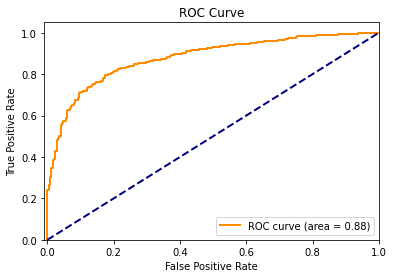

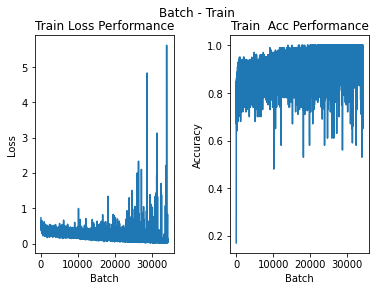

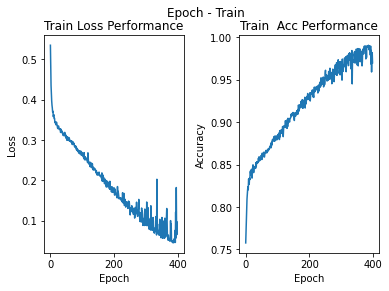

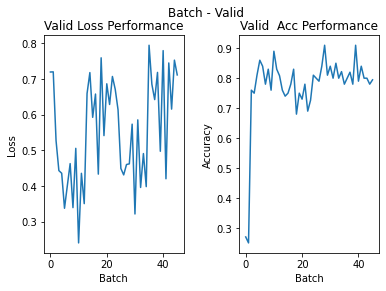

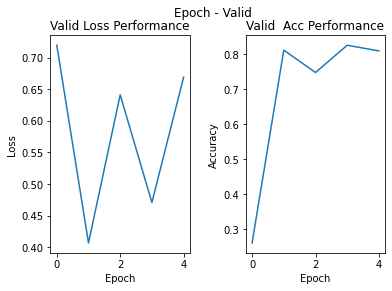

In [ ]:
from matplotlib.pyplot import cm
#from platiagro import save_figure
#from platiagro import list_figures
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
import matplotlib.pyplot as plt

y_pred = list(model.df_test['PREDICTED_CODE']) 
y_prob =  [[a,b] for a,b in zip(list(model.df_test['REQ_PROBA']),list(model.df_test['INC_PROBA']))]

def plot_roc_curve(y_test,y_prob,labels):
    n_classes = len(labels)
    y_test = list(y_test)
    y_prob=np.array(y_prob)

    if n_classes == 2:
        # Compute ROC curve 
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)  
        
        # Plot ROC Curve
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    else:  
        # Binarize the output
        lb = preprocessing.LabelBinarizer()
        y_test_bin = lb.fit_transform(y_test)

        # Compute ROC curve for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()  

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        color=cm.rainbow(np.linspace(0,1,n_classes+1))
        plt.figure()
        lw = 2
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        for i,c in zip(range(n_classes),color):                   
            plt.plot(fpr[i], tpr[i], color=c,
             lw=lw, label='ROC curve - Class %s (area = %0.2f)' % (labels[i] ,roc_auc[i]))
            plt.title('ROC Curve One-vs-Rest')
            plt.legend(loc="lower right")
        
        plt.show()

#funciona apenas quando se treina o modelo, quando recupera os pesos aparentemente não está
def performance_visualization(loss_list, acc_list,epoch_or_batch="Epoch",step = "Train"):

    x = range(len(loss_list))
    plt.title(step + ' Loss Performance')
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.xlabel(epoch_or_batch)
    plt.ylabel("Loss")
    plt.plot(x, loss_list, '-')
    plt.title(step + ' Loss Performance')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.xlabel(epoch_or_batch)
    plt.ylabel("Accuracy")
    plt.plot(x, acc_list, '-')
    plt.title(step + '  Acc Performance')

    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(epoch_or_batch + ' - ' + step)
    plt.show()

#Plotando as curvas
plot_roc_curve(y_test,y_prob,labels)
if not weights_retrieved:
  performance_visualization(model.df_performance_train_batch['train_batch_loss'].to_numpy(), model.df_performance_train_batch['train_batch_acc'].to_numpy(),epoch_or_batch="Batch",step = "Train")
  performance_visualization(model.df_performance_train_epoch['train_epoch_loss'].to_numpy(), model.df_performance_train_epoch['train_epoch_acc'].to_numpy(),epoch_or_batch="Epoch",step = "Train")
  performance_visualization(model.df_performance_valid_batch['valid_batch_loss'].to_numpy(), model.df_performance_valid_batch['valid_batch_acc'].to_numpy(),epoch_or_batch="Batch",step = "Valid")
  performance_visualization(model.df_performance_valid_epoch['valid_epoch_loss'].to_numpy(), model.df_performance_valid_epoch['valid_epoch_acc'].to_numpy(),epoch_or_batch="Epoch",step = "Valid")

## Salva modelo e outros artefatos

Modelo Pytorch Lightining

In [ ]:
file_name = 'pytorch_model.pt'
torch.save(model.state_dict(), f'/tmp/data/{file_name}')

Artefatos

In [ ]:
import pickle
dataset_infos = {'all_data':all_data}
deployment_infos = {'columns':columns,'X_test':X_test,'glove_vocab':glove_vocab}
artifacts = {'hyperparams':hyperparams,'model_parameters':model_parameters,'dataset_infos':dataset_infos,'extra_infos':extra_infos,'deployment_infos':deployment_infos}
file_name = 'artifacts.p'
pickle.dump(artifacts, open(f'/tmp/data/{file_name}', "wb" ))